### CNNs: classificazione di immagini con una CNN di tipo VGG, e uso di una rete pre-addesrata tramite tecniche di transfer learning

Scopo:
- familiarizzare con l'implementazione di CNN in pytorch
- imparare a come sfruttare modelli SOTA CNN preaddestrati su imagnet per task specifiche utilizzando la tecnica del transfer learning


**Dataset:**

Sign Language Digits Dataset
(Turkey Ankara Ayrancı Anadolu High School Students: [github-link](https://github.com/ardamavi/Sign-Language-Digits-Dataset))

Image size: 100 x 100 pixels

Color space: RGB
Number of classes: 10 (Digits: 0-9)
Number of participant students: 218
Number of samples per student: 10

In [4]:
#@title Download del dataset (esegui la cella)
!rm -rf Dataset.zip
!rm -rf Dataset_test.zip
!rm -rf Dataset
!rm -rf Dataset_test
!wget http://giagu.web.cern.ch/giagu/CERN/Dataset.zip
!wget http://giagu.web.cern.ch/giagu/CERN/Dataset_test.zip
!unzip -q Dataset.zip
!unzip -q Dataset_test.zip
!rm -rf __MACOSX

--2025-04-15 10:23:04--  http://giagu.web.cern.ch/giagu/CERN/Dataset.zip
Resolving giagu.web.cern.ch (giagu.web.cern.ch)... 188.185.5.88, 188.185.18.46, 188.185.50.104, ...
Connecting to giagu.web.cern.ch (giagu.web.cern.ch)|188.185.5.88|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://giagu.web.cern.ch/giagu/CERN/Dataset.zip [following]
--2025-04-15 10:23:05--  https://giagu.web.cern.ch/giagu/CERN/Dataset.zip
Connecting to giagu.web.cern.ch (giagu.web.cern.ch)|188.185.5.88|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11254421 (11M) [application/zip]
Saving to: ‘Dataset.zip’

Dataset.zip         100%[===================>]  10.73M  5.91MB/s    in 1.8s    

2025-04-15 10:23:07 (5.91 MB/s) - ‘Dataset.zip’ saved [11254421/11254421]

--2025-04-15 10:23:07--  http://giagu.web.cern.ch/giagu/CERN/Dataset_test.zip
Resolving giagu.web.cern.ch (giagu.web.cern.ch)... 188.185.50.104, 188.185.18.46, 188.185.5.88, ...
Connecting to gia

Nei folder Dataset e Dataset_test sono contenute le immagini in formato jpeg. Le immagini corrispondenti ai differenti numeri (0,1,2,3,4,5,6,7,9) sono inserite in sub-folders nominati in accordo al digit corrispondente

In [5]:
!ls Dataset/
!ls Dataset_test/
!ls Dataset/0/

0  1  2  3  4  5  6  7	8  9
0  1  2  3  4  5  6  7	8  9
IMG_1118.JPG  IMG_5028.JPG  IMG_5276.JPG  IMG_5527.JPG	IMG_5766.JPG
IMG_1128.JPG  IMG_5042.JPG  IMG_5286.JPG  IMG_5537.JPG	IMG_5776.JPG
IMG_1138.JPG  IMG_5053.JPG  IMG_5297.JPG  IMG_5547.JPG	IMG_5786.JPG
IMG_1148.JPG  IMG_5063.JPG  IMG_5308.JPG  IMG_5562.JPG	IMG_5796.JPG
IMG_1158.JPG  IMG_5074.JPG  IMG_5318.JPG  IMG_5572.JPG	IMG_5806.JPG
IMG_1169.JPG  IMG_5091.JPG  IMG_5328.JPG  IMG_5582.JPG	IMG_5816.JPG
IMG_1179.JPG  IMG_5101.JPG  IMG_5341.JPG  IMG_5592.JPG	IMG_5826.JPG
IMG_1189.JPG  IMG_5111.JPG  IMG_5350.JPG  IMG_5603.JPG	IMG_5837.JPG
IMG_1199.JPG  IMG_5122.JPG  IMG_5360.JPG  IMG_5615.JPG	IMG_5847.JPG
IMG_1209.JPG  IMG_5132.JPG  IMG_5370.JPG  IMG_5625.JPG	IMG_5857.JPG
IMG_1219.JPG  IMG_5142.JPG  IMG_5380.JPG  IMG_5635.JPG	IMG_5867.JPG
IMG_1229.JPG  IMG_5152.JPG  IMG_5390.JPG  IMG_5645.JPG	IMG_5877.JPG
IMG_1239.JPG  IMG_5163.JPG  IMG_5400.JPG  IMG_5655.JPG	IMG_5887.JPG
IMG_1249.JPG  IMG_5173.JPG  IMG_5412.JPG  IMG_5665.JPG	IMG_5

## Lettura del dataset e preparazione dei dataloader pytorch

In [6]:
import os.path
from torchsummary import summary

import torch
import torchvision
print(torch.__version__)
print(torchvision.__version__)

from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models

# transforms fa trasformazioni ai dati; le immagini jpg vanno trasformate in tensori torch

import numpy as np
import matplotlib.pyplot as plt

from PIL import Image  # comodo per lavorare con immagini jpg

2.6.0+cu124
0.21.0+cu124


In [7]:
# lettura dei dati usando torchvision

data_dir = 'Dataset'
test_dir = 'Dataset_test'

# definizione di un torchvision transform costituito da una composizione di trasformazioni utili
# di processamento dei dati e data augmentation

train_transforms = transforms.Compose([#transforms.RandomRotation(10), #applica una rotazione random +/- 10 deg
                                       #transforms.RandomHorizontalFlip(), #applica un flip random dei pixel orizontal
                                       transforms.Resize((100,100)), #assicura che l'immagine sia 100x100
                                       transforms.ToTensor(), #converte in tensori torch
                                      ])

# la data augmentation è applicata solo alle immagini di training
test_transforms = test_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                      ])


# trochvision.datasets mette a disposizione la funzione ImageFolder che permete di creare un dataset a partire da immagini
# salvate in folder sul filesystem, automaticamente associa label alle immagini se queste sono salvate in subfolders
# https://pytorch.org/vision/stable/generated/torchvision.datasets.ImageFolder.html#torchvision.datasets.ImageFolder

train_data = datasets.ImageFolder(data_dir, transform=train_transforms)
testing_data = datasets.ImageFolder(test_dir, transform=test_transforms)

print(train_data)
print(testing_data)

# split test set in vali e test usando pytorch (funzione torch.utils.data.random_split)
test_data, vali_data = torch.utils.data.random_split(testing_data, [450,455])
# split in 450 per test e 455 per validation. Posso dare anche percentuali

print('Training set size: ', len(train_data))
print('Validation set size: ',len(vali_data))
print('Test set size: ',len(test_data))

# dataloaders
batch_size = 64
dataloaders = dict()  # uso un dizionario per comodità
dataloaders['train'] = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
dataloaders['vali'] = torch.utils.data.DataLoader(vali_data, batch_size=batch_size, shuffle=True)
dataloaders['test'] = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)

Dataset ImageFolder
    Number of datapoints: 1157
    Root location: Dataset
    StandardTransform
Transform: Compose(
               Resize(size=(100, 100), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )
Dataset ImageFolder
    Number of datapoints: 905
    Root location: Dataset_test
    StandardTransform
Transform: Compose(
               ToTensor()
           )
Training set size:  1157
Validation set size:  455
Test set size:  450


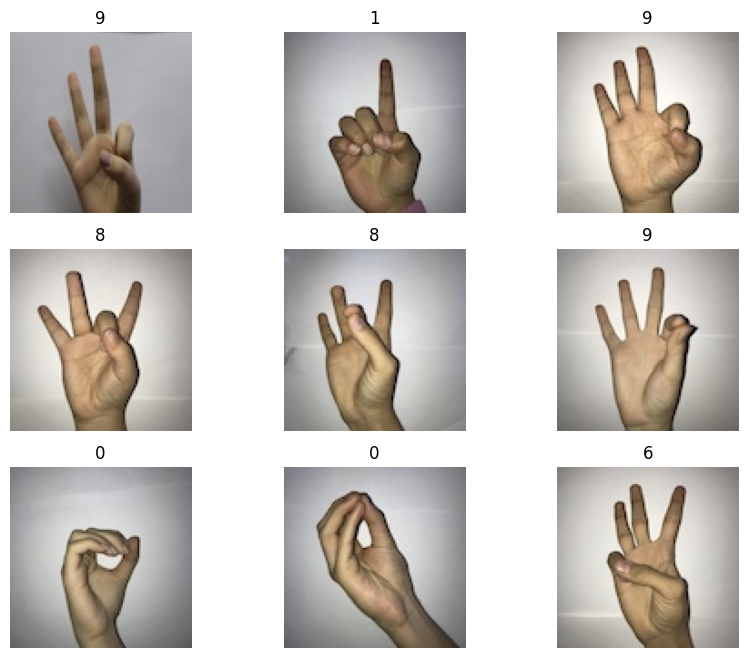

In [8]:
# plot di alcune immagini

figure = plt.figure(figsize=(10, 8))
cols, rows = 3,3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.permute(1,2,0))  # nota: imshow si aspetta immagini con shape (h,w,channel) mentre i tensori torch hanno shape (channel, h, w)
plt.show()

In [9]:
# controlliamo se la GPU è disponibile e nel caso quale tipo di GPU
if torch.cuda.is_available():
  print('Numero di GPU disponibili: ',torch.cuda.device_count())
  for i in range(0,torch.cuda.device_count()):
    print(torch.cuda.get_device_name(i))

# se la GPU è disponibile imposto device='cuda', altrimenti 'cpu'
device = ('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Computation device: {device}\n")

Numero di GPU disponibili:  1
Tesla T4
Computation device: cuda



In [10]:
# Convolutional Neural Network (VGG-like architecture)

# Implementare un modello convoluzionale composto da 3 blocchi convoluzionali costituiti
# ciascuno da:

# 1 layer conv2D (nn.Conv2d) con kernel_size=(3,3)
# 1 layer di max pooling (nn.MaxPool2d) con kernel_size=(2,2)

# i layer conv2D devono essere costituiti da rispettivamente 16, 16 e 32 filtri
# quindi il primo layer convoluzionale entra con 3 canali e esce con 16
# il secondo layer convoluzionale entra con 16 canali e esce con 16
# il terzo layer convoluzionale entra con 16 canali e esce con 32

# l'output del terzo blocco convoluzionale deve essere appiattito in un vettore 1D tramite
# il layer (nn.Flatten())

# l'output flattened deve essere passato ad un MLP per la classificazione a 10 classi finali
# costituito da 3 layer densi con 64 neuroni l'uno, intervallati da layer di droput con probabilità 0.5
# e funzioni di attivazione ReLu

from torch import nn
import torch.nn.functional as F

class myVGG(nn.Module):
  def __init__(self):
    super(myVGG, self).__init__()

    # definizione dei layer

    # primo blocco convoluzionale
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=(3,3))
    self.pool1 = nn.MaxPool2d(kernel_size=(2,2))

    # secondo blocco convoluzionale
    self.conv2 =  nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3,3))
    self.pool2 = nn.MaxPool2d(kernel_size=(2,2))

    # terzo blocco convoluzionale
    self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3,3))
    self.pool3 = nn.MaxPool2d(kernel_size=(2,2))

    # flatten
    self.flatten = nn.Flatten()

    # MLP
    self.drop1 = nn.Dropout(p=0.5)
    self.fc1 = nn.Linear(in_features=3200, out_features=64)  # in_features prende 3200 che è l'output di flatten e non lo conosco a priori; quello che devo fare è stampare questo output e scoprire quanto è
    self.drop2 = nn.Dropout(p=0.5)
    self.fc2 = nn.Linear(in_features=64, out_features=64)
    self.fc3 = nn.Linear(in_features=64, out_features=10)

  # forward pass: x (input) -> out
  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = self.pool1(x)
    x = F.relu(self.conv2(x))
    x = self.pool3(x)
    x = F.relu(self.conv3(x))
    x = self.pool3(x)

    x = self.flatten(x)

    x = self.drop1(x)
    x = F.relu(self.fc1(x))
    x = self.drop2(x)
    x = F.relu(self.fc2(x))

    out = self.fc3(x)

    return out

In [11]:
# stampa del modello

model = myVGG()
print(model)

from torchsummary import summary
if torch.cuda.is_available():
  summary(model.cuda(), input_size=(3,100,100))  # input size così perchè è una foto: prima canali, poi pixel orizzontali e poi quelli verticali
else:
  summary(model, input_size=(3,100,100))

myVGG(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (drop1): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=3200, out_features=64, bias=True)
  (drop2): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 98, 98]             448
         MaxPool2d

In [12]:
# test di un batch sul modello non addestrato per vedere che le cose funzionano

# leggere un batch da dataloaders['train']
# spostare su device modello e dati
# calcolare la predizione del modello
# stampare la shape dei dati in input, in output e il valore dell'output del primo
# evento del batch

feat, label = next(iter(dataloaders['train']))
feat = feat.to(device)
label = label.to(device)
model.to(device)

out = model(feat)

print(out.shape)
print(out[0])
print(F.softmax(out, dim=1)[0])

torch.Size([64, 10])
tensor([-0.1384,  0.0501, -0.0886,  0.0827, -0.0370, -0.1126, -0.1791,  0.0722,
         0.0509, -0.1151], device='cuda:0', grad_fn=<SelectBackward0>)
tensor([0.0904, 0.1091, 0.0950, 0.1127, 0.1000, 0.0927, 0.0868, 0.1116, 0.1092,
        0.0925], device='cuda:0', grad_fn=<SelectBackward0>)


In [13]:
#install torchmetrics: collection of useful PyTorch metrics implementations and an easy-to-use API to create custom metrics
%pip install torchmetrics

In [14]:
# loss function, accuracy, optimzer

loss_func =  nn.CrossEntropyLoss()
from torchmetrics.classification import Accuracy

# metric accuracy
from torchmetrics.classification import Accuracy
metric_fun = Accuracy(task="multiclass", num_classes=10)
metric_fun = metric_fun.to(device)  # NOTA: va spostata anche essa nel device in cui si esegue il cacolo e sono presenti i tensori

# ottmizzatore: uso Adam
from torch import optim
LR_ST = 1e-3
opt =  optim.Adam(model.parameters(), lr=LR_ST)

# aggiungiamo uno scheduler per il LR che diminusice il LR a intervalli fissati
# ogni 15 epoche riduce il learning rate di un fattore gamma: lr = lr*gamma
scheduler = optim.lr_scheduler.StepLR(opt, 15, gamma=0.1, last_epoch=-1, verbose=True)

In [15]:
# Checkpoints functions
# attraverso i checkpoints possiamo interagire con il modello durante il runtime
# Per esempio si puo' salvare il modello ad ogni epoca

# Checkpoint per salvare il modello durante il training (solo il best model)
# salviamo non solo il modello ma anche alcuni metadati addizionali che possono essere utili
# salviamo le informazioni in un dizionario python che associa a diverse chiavi
# diverse informazioni

class SaveBestModel:
    def __init__(self, best_valid_loss=float('inf')): #object initialized with best_loss = +infinite
        self.best_valid_loss = best_valid_loss

    def __call__(
        self, current_valid_loss,
        epoch, model, optimizer, criterion, metric,
    ):
        if current_valid_loss < self.best_valid_loss:
            self.best_valid_loss = current_valid_loss

            print(f"\nBest validation loss: {self.best_valid_loss}")
            print(f"\nSaving best model for epoch: {epoch+1}\n")

            # method to save a model (the state_dict: a python dictionary object that
            # maps each layer to its parameter tensor) and other useful parametrers
            # see: https://pytorch.org/tutorials/beginner/saving_loading_models.html

            torch.save({'model' : model,
                'epoch': epoch+1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': criterion,
                'metric': metric,
                }, 'best_model.pt')

In [16]:
# Training function

import time

def train_model(nn_model, criterion, metric, n_epochs, dl_train, dl_vali):


  # liste su cui salvare il valore della loss e della metrica ad ogni epoca per poterli graficare in funzione
  # dell'epoca a fine addestramento
  hist_loss = []
  hist_metric = []
  hist_vloss = []
  hist_vmetric = []


  # loop sulle epoche
  for epoch in range(n_epochs):
    t0 = time.time()

    # training step (in cui aggiorniamo i pesi della rete neurale)
    model.train()
    train_loss = 0
    train_metric = 0
    counter = 0
    for xb, yb in dl_train:
        counter += 1
        xb=xb.to(device)  # copio il mini batch di dati sulla CPU/GPU
        yb=yb.to(device)

        pred = nn_model(xb)  # predizione del modello

        # calcolo loss e metrica
        loss = criterion(pred, yb)
        if metric != None:
          tmetric = metric(pred, yb)

        # aggiorno la loss e metrica totale
        train_loss += loss.item()
        if metric != None:
          train_metric += tmetric.item()

        # backpropagation
        opt.zero_grad()  # resetta i gradienti prima di eseguire la backpropagation (importante!)
        loss.backward()  # calcola i gradeinti della loss
        opt.step()  # aggiorna i pesi


    train_loss /= counter
    hist_loss.append(train_loss)

    if metric != None:
      train_metric /= counter
      hist_metric.append(train_metric)


    # validation step (non vengono aggiornati i pesi)
    model.eval()
    vali_loss = 0
    vali_metric = 0
    counter = 0
    with torch.no_grad():  # evita che vengano cacolati automaticamente i gradienti
      for xb, yb in dl_vali:
        counter += 1
        xb=xb.to(device)
        yb=yb.to(device)

        pred = nn_model(xb)  # predizione del modello

        # calcolo loss e metrica
        vloss = criterion(pred, yb)
        vali_loss += vloss.item()

        if metric != None:
          vmetric = metric(pred, yb)
          vali_metric += vmetric.item()

    vali_loss /= counter
    hist_vloss.append(vali_loss)

    if metric != None:
      vali_metric /= counter
      hist_vmetric.append(vali_metric)


    elapsed_time = time.time()-t0
    if metric != None:
      print("epoch: %d, time(s): %.4f, train loss: %.6f, train metric: %.6f, vali loss: %.6f, vali metric: %.6f"
            % (epoch+1, elapsed_time, train_loss, train_metric, vali_loss, vali_metric))
    else:
      print("epoch: %d, time(s): %.4f, train loss: %.6f, vali loss: %.6f"
            % (epoch+1, elapsed_time, train_loss, vali_loss))

    # save best model
    save_best_model(vali_loss, epoch, model, opt, loss_func, metric_fun)

    # aggiornamento learning rate scheduler
    scheduler.step()

  return nn_model, hist_loss, hist_metric, hist_vloss, hist_vmetric

In [17]:
# Training

model = myVGG()
model.to(device)
opt = optim.Adam(model.parameters(), lr=LR_ST)
scheduler = optim.lr_scheduler.StepLR(opt, 15, gamma=0.1, last_epoch=-1, verbose=True)
metric_fun = metric_fun.to(device)

# numero di epoche
epochs = 40

save_best_model = SaveBestModel()

model, hist_loss, hist_metric, hist_vloss, hist_vmetric = train_model(nn_model=model, criterion=loss_func, metric=metric_fun, n_epochs=epochs, dl_train=dataloaders['train'], dl_vali=dataloaders['vali'])

epoch: 1, time(s): 2.4149, train loss: 2.305686, train metric: 0.110033, vali loss: 2.306700, vali metric: 0.089844

Best validation loss: 2.306699752807617

Saving best model for epoch: 1

epoch: 2, time(s): 2.8027, train loss: 2.303161, train metric: 0.105099, vali loss: 2.298810, vali metric: 0.089844

Best validation loss: 2.2988097965717316

Saving best model for epoch: 2

epoch: 3, time(s): 2.9955, train loss: 2.291235, train metric: 0.131414, vali loss: 2.249915, vali metric: 0.305246

Best validation loss: 2.249915212392807

Saving best model for epoch: 3

epoch: 4, time(s): 3.1421, train loss: 2.166979, train metric: 0.212829, vali loss: 1.839806, vali metric: 0.361328

Best validation loss: 1.839806228876114

Saving best model for epoch: 4

epoch: 5, time(s): 3.7661, train loss: 1.755476, train metric: 0.350822, vali loss: 1.225597, vali metric: 0.677176

Best validation loss: 1.2255970388650894

Saving best model for epoch: 5

epoch: 6, time(s): 2.1539, train loss: 1.492826,

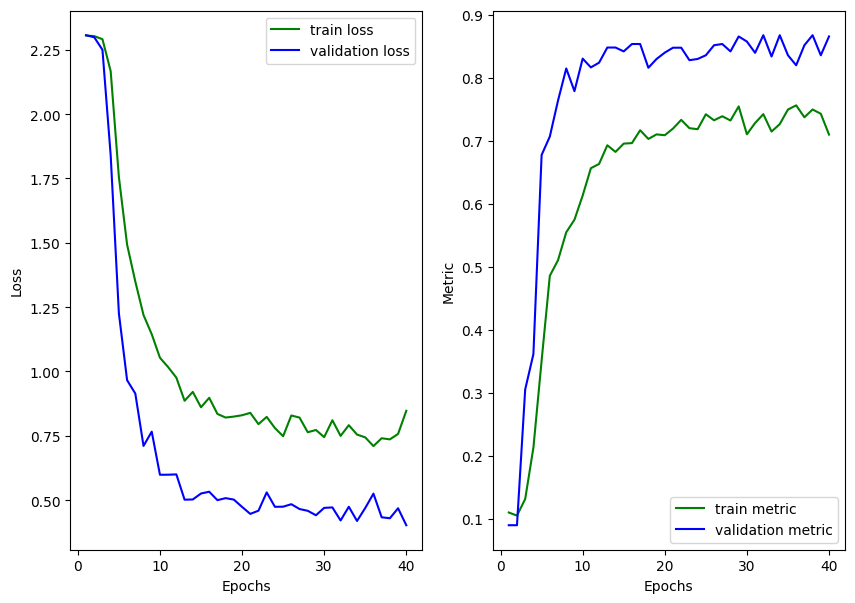

In [18]:
# grafico monitoring training
plt.figure(figsize=(10, 7))
plt.subplot(1,2,1)
plt.plot(range(1,len(hist_loss)+1), hist_loss, color='green', linestyle='-', label='train loss')
plt.plot(range(1,len(hist_vloss)+1), hist_vloss, color='blue', linestyle='-', label='validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(range(1,len(hist_metric)+1),hist_metric, color='green', linestyle='-', label='train metric')
plt.plot(range(1,len(hist_vmetric)+1),hist_vmetric, color='blue', linestyle='-', label='validation metric')
plt.xlabel('Epochs')
plt.ylabel('Metric')
plt.legend()
plt.show()

# molto rumorose perchè il campione è piccolo (tante fluttuazioni); va meglio sul validation perchè sto usando dropout: il modello che uso nel train ha dropout mentre quello che uso nel
# vali è il modello completo, quindi da' risultati migliori ovviamente

In [19]:
# test set perfromance

# lettura del modello
model_data = torch.load('./best_model.pt', weights_only=False)
print('Best model at epoch: ', model_data['epoch'])
model = model_data['model']
model.eval()  # va sempre fatto per settare eventuali layer di droput e batch norm in evaluation model

# Non è strettamento necessario girare sulla GPU per l'inferenza (non richiede grande potenza di calcolo)
model.to(torch.device('cpu'))
metric_fun = metric_fun.to('cpu')

loss = 0
metric = 0
counter = 0

for xb, yb in dataloaders['test']:
  counter += 1
  xb=xb.to('cpu')
  yb=yb.to('cpu')
  pred = model(xb)

  loss += loss_func(pred, yb).item()
  metric += metric_fun(pred, yb).item()


loss /= counter
metric /= counter

print('Test loss/accuracy: ',loss, ' / ', metric)

Best model at epoch:  40
Test loss/accuracy:  0.5079638324677944  /  0.8125


In [20]:
# confusion matrix

def print_cm(cm, labels, hide_zeroes=False, hide_diagonal=False, hide_threshold=None):
    """pretty print for confusion matrixes"""
    columnwidth = max([len(x) for x in labels] + [5])  # 5 is value length
    empty_cell = " " * columnwidth
    # Print header
    print("    " + empty_cell, end=" ")
    for label in labels:
        print("%{0}s".format(columnwidth) % label, end=" ")
    print()

    # Print rows
    for i, label1 in enumerate(labels):
        print("    %{0}s".format(columnwidth) % label1, end=" ")
        for j in range(len(labels)):
            cell = "%{0}.2f".format(columnwidth) % cm[i, j]
            if hide_zeroes:
                cell = cell if float(cm[i, j]) != 0 else empty_cell
            if hide_diagonal:
                cell = cell if i != j else empty_cell
            if hide_threshold:
                cell = cell if cm[i, j] > hide_threshold else empty_cell
            print(cell, end=" ")
        print()

predictions = np.empty(shape=(0,))
truths = np.empty(shape=(0,))

for xb, yb in dataloaders['test']:
  counter += 1
  xb=xb.to('cpu')
  yb=yb.to('cpu')
  pred = model(xb)

  res = torch.argmax(pred, dim=1)

  predictions = np.concatenate((predictions,res.detach().numpy()))
  truths = np.concatenate((truths,yb.detach().numpy()))

from sklearn.metrics import confusion_matrix
c_mat = confusion_matrix(predictions, truths, normalize='true')
print("Confusion Matrix:")
labels = ['0','1','2','3','4','5','6','7','8','9']
print_cm(c_mat, labels)

Confusion Matrix:
              0     1     2     3     4     5     6     7     8     9 
        0  0.95  0.00  0.00  0.00  0.00  0.00  0.00  0.03  0.03  0.00 
        1  0.02  0.90  0.00  0.07  0.00  0.00  0.00  0.00  0.00  0.00 
        2  0.00  0.00  0.84  0.04  0.00  0.00  0.06  0.06  0.00  0.00 
        3  0.00  0.00  0.00  1.00  0.00  0.00  0.00  0.00  0.00  0.00 
        4  0.00  0.00  0.00  0.00  0.76  0.09  0.07  0.07  0.00  0.02 
        5  0.00  0.00  0.00  0.02  0.00  0.91  0.00  0.00  0.02  0.04 
        6  0.03  0.00  0.00  0.00  0.03  0.00  0.91  0.00  0.03  0.00 
        7  0.04  0.02  0.00  0.00  0.02  0.00  0.02  0.81  0.06  0.02 
        8  0.00  0.00  0.00  0.00  0.09  0.04  0.11  0.07  0.68  0.02 
        9  0.00  0.00  0.00  0.00  0.02  0.06  0.02  0.00  0.02  0.88 


### Risolviamo la task di classificazione utilizzando una rete CNN preaddestrata su un grande dataset (imagenet) e applicando una tecnica di transfer learning:


1.   si definisce e carica un modello preaddestrato da pytorch
2.   si modifica l'MLP finale del modello adattandolo al nostro task specifico (per esempio classificazione a 10 classi)
3.   si congelano i pesi dei blocchi convoluzionali e si addestra solo l'MLP sul nostro dataset
4.   si rilasciano i pesi dei layer convoluzionali e si fa un fine tuning (training di poche eopoche con un learning rate molto piccolo)



In [21]:
# carichiamo uno dei modelli preaddestrati da torchvision
from torchvision import datasets, transforms, models

# esempio densenet121
model = models.densenet121(pretrained= True)  # già allenato per task di classificazione su altre immagini. pretrained = True, cioè già allenato

print(model)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [22]:
# esce con 1000 classi, quindi vado a modificare questo ultimo classifier e ci metto il mio, allenando poi solo questo pezzo che modifico (non modifico altri pesi)

In [23]:
# congelo i parametri del modello

for param in model.parameters():
    param.requires_grad = False  # congela il parametro in esame

# aggiungo l'MLP per la classificazione

# OrderedDict è una versione più sofisiticata dei dizionari di python che permette di ricordare l'ordine
# in cui gli elementi sono stati aggiunti al dizionario
from collections import OrderedDict


# vedi bene cosa fa Sequential: vedi nota sotto
classifier = nn.Sequential(OrderedDict([  # MLP, metto input e output della dimensione che voglio
    ('dropout1',nn.Dropout(0.5)),
    # define the inputs must be 1024 for densent121 model
    ('fc1',nn.Linear(1024,64)),
    ('relu1', nn.ReLU()),
    ('dropout2',nn.Dropout(0.5)),
    ('fc2',nn.Linear(64,64)),
    ('relu2', nn.ReLU()),
    ('output',nn.Linear(64,10)),
    #('output', nn.LogSoftmax(dim=1))
]))

model.classifier = classifier  # sovrascrivo con il mio classificatiore

**nn.Sequential**

 E' una classe fornita da PyTorch che consente di costruire rapidamente modelli di reti neurali componendo insieme una serie di moduli (layers) in sequenza. È particolarmente utile per definire modelli che seguono una struttura lineare, dove i dati passano attraverso ogni strato in ordine, senza biforcazioni o collegamenti complessi tra strati.

 **OrderedDict**

 In PyTorch può essere utile quando si definisce un modello con nn.Sequential e si desidera specificare i nomi dei layer. Questo può rendere il modello più leggibile e permette di accedere facilmente ai layer per nome.
 Mantiene l'ordine di inserimento degli elementi, il che significa che quando si itera su un OrderedDict, gli elementi vengono restituiti nell'ordine in cui sono stati aggiunti.

In [24]:
# loss e ottmizzatore (come prima)

loss_func = nn.CrossEntropyLoss() #cross entropy loss
# loss_func = nn.NLLLoss()

# metric accuracy
from torchmetrics.classification import Accuracy

metric_fun = Accuracy(task="multiclass", num_classes=10)
metric_fun = metric_fun.to(device) #NOTA: va spostata anche essa nel device in cui si esegue il cacolo e sono presenti i tensori

# ottmizzatore: usiamo Adam
from torch import optim
LR_ST = 1e-3
opt = optim.Adam(model.parameters(), lr=LR_ST)

In [25]:
# devo ricostruire il dataset

# dati: densenet121 richiede immagini in input didimensione 224x224 (è stato addestrato con immagini
# di imagnet di quella dimensione, dobbiamo fare un resize delle immagini del nostro campione)

# lettura dei dati usando torchvision

data_dir = 'Dataset'
test_dir = 'Dataset_test'

# definizione di un torchvision transform costituito da una composizione di trasformazioni utili
# di processamento dei dati e data augmentation

train_transforms = transforms.Compose([#transforms.RandomRotation(10), #applica una rotazione random +/- 10 deg
                                       #transforms.RandomHorizontalFlip(), #applica un flip random dei pixel orizontal
                                       transforms.Resize((224,224)), #assicura che l'immagine sia 224,224
                                       transforms.ToTensor(), #converte in tensori torch
                                      ])

# la data augmentation è applicata solo alle immagini di training
test_transforms = test_transforms = transforms.Compose([
                                       transforms.Resize((224,224)),
                                       transforms.ToTensor(),
                                      ])

# tutto il resto è uguale


# trochvision.datasets mette a disposizione la funzione ImageFolder che permete di creare un dataset a partire da imagini
# salvate in folder sul filesystem, automaticamente associa label alle immagini se queste sono salvate in
# subfolders
# https://pytorch.org/vision/stable/generated/torchvision.datasets.ImageFolder.html#torchvision.datasets.ImageFolder

train_data = datasets.ImageFolder(data_dir, transform=train_transforms)
testing_data = datasets.ImageFolder(test_dir, transform=test_transforms)

print(train_data)
print(testing_data)

# split test set in vali e test
test_data, vali_data = torch.utils.data.random_split(testing_data, [450, 455])

print('Trainign set size: ', len(train_data))
print('Validation set size: ',len(vali_data))
print('Test set size: ',len(test_data))

# dataloaders

batch_size = 64
dataloaders = dict() #usiamo un dizionario epr comodità
dataloaders['train'] = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
dataloaders['vali'] = torch.utils.data.DataLoader(vali_data, batch_size=batch_size, shuffle=True)
dataloaders['test'] = torch.utils.data.DataLoader(test_data, batch_size=16, shuffle=True)


Dataset ImageFolder
    Number of datapoints: 1157
    Root location: Dataset
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )
Dataset ImageFolder
    Number of datapoints: 905
    Root location: Dataset_test
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )
Trainign set size:  1157
Validation set size:  455
Test set size:  450


In [26]:
# Training: addestro solo il classifier, non avrà performance perfette

model.to(device)

# numero di epoche
epochs = 20

model, hist_loss, hist_metric, hist_vloss, hist_vmetric = train_model(nn_model=model, criterion=loss_func, metric=metric_fun, n_epochs=epochs, dl_train=dataloaders['train'], dl_vali=dataloaders['vali'])

epoch: 1, time(s): 8.0471, train loss: 2.289595, train metric: 0.133717, vali loss: 2.261122, vali metric: 0.193638
epoch: 2, time(s): 8.5383, train loss: 2.218853, train metric: 0.194737, vali loss: 2.133333, vali metric: 0.413225
epoch: 3, time(s): 8.6933, train loss: 2.117161, train metric: 0.261513, vali loss: 1.899407, vali metric: 0.583705
epoch: 4, time(s): 8.2968, train loss: 1.889241, train metric: 0.345230, vali loss: 1.575096, vali metric: 0.530134
epoch: 5, time(s): 9.0115, train loss: 1.709034, train metric: 0.392928, vali loss: 1.291066, vali metric: 0.734096
epoch: 6, time(s): 8.6423, train loss: 1.554000, train metric: 0.451151, vali loss: 1.144575, vali metric: 0.712333
epoch: 7, time(s): 8.4668, train loss: 1.466839, train metric: 0.443092, vali loss: 1.077071, vali metric: 0.670480
epoch: 8, time(s): 8.5520, train loss: 1.410827, train metric: 0.485526, vali loss: 0.989479, vali metric: 0.741908
epoch: 9, time(s): 8.7574, train loss: 1.318880, train metric: 0.526480,

In [27]:
torch.save(model, './densenet121_model.pt')

In [29]:
# fine tuning: unfreeze dei pesi, setto lr ad un numero molto piccolo (1e-4 o 1e-5) e riaddestro per poche epoche ...

# NOTA: si continua addestrando il modello precedentemente addestrato, non si crea un nuovo modello
model = torch.load('./densenet121_model.pt', weights_only=False)
model.to(device)

for param in model.parameters():
    param.requires_grad = True  # tutti addestrabili

LR_ST = 1e-5
opt = optim.Adam(model.parameters(), lr=LR_ST)


# numero di epoche
epochs = 10

model, hist_loss, hist_metric, hist_vloss, hist_vmetric = train_model(nn_model=model, criterion=loss_func, metric=metric_fun, n_epochs=epochs, dl_train=dataloaders['train'], dl_vali=dataloaders['vali'])

# guadagno accuracy rispetto al VGG fatto prima

epoch: 1, time(s): 15.7401, train loss: 1.000545, train metric: 0.635855, vali loss: 0.546714, vali metric: 0.857422
epoch: 2, time(s): 13.6797, train loss: 0.858832, train metric: 0.674836, vali loss: 0.476100, vali metric: 0.884487
epoch: 3, time(s): 13.7468, train loss: 0.738500, train metric: 0.750000, vali loss: 0.493728, vali metric: 0.888393
epoch: 4, time(s): 13.7261, train loss: 0.782018, train metric: 0.707072, vali loss: 0.417972, vali metric: 0.911830
epoch: 5, time(s): 13.6217, train loss: 0.628378, train metric: 0.796053, vali loss: 0.370368, vali metric: 0.907924

Best validation loss: 0.3703682906925678

Saving best model for epoch: 5

epoch: 6, time(s): 14.0751, train loss: 0.589256, train metric: 0.787171, vali loss: 0.367416, vali metric: 0.927455

Best validation loss: 0.3674161471426487

Saving best model for epoch: 6

epoch: 7, time(s): 14.3834, train loss: 0.567054, train metric: 0.808059, vali loss: 0.320589, vali metric: 0.949219

Best validation loss: 0.320588